In [19]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from etl_functions import load_data, build_feat_info, bar_plt_nan, replace_nan, clean_data, plot_comparison
from collections import Counter
from operator import itemgetter
import time
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
import itertools
import random

# magic word for producing visualizations in notebook
%matplotlib inline

### Load Data
Since the dataset is more than 1GB, I've used `c` engine instead of `python` to load data faster. In addition, there are mixed data in column 18 & 19; more specifically some `NaN` values are represented by `X` & `XX`. These values are set as `na_values`.

In [2]:
%%time
azdias_filepath = "Udacity_AZDIAS_052018.csv"
customers_filepath = "Udacity_CUSTOMERS_052018.csv"
attributes_filepath = "DIAS Attributes - Values 2017.xlsx"
attributes_desc_filepath = "DIAS Information Levels - Attributes 2017.xlsx"

azdias, customers, attributes, attributes_desc = load_data(azdias_filepath, customers_filepath, attributes_filepath,
                                                         attributes_desc_filepath)

Wall time: 35.9 s


### Explore the Datasets

In [3]:
print("General population dataset, azdias shape: ", azdias.shape)
print("Customers dataset, customers shape: ", customers.shape)

General population dataset, azdias shape:  (891221, 366)
Customers dataset, customers shape:  (191652, 369)


In [4]:
# Drop redundant columns from customers
customers.drop(columns=["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"], inplace=True)

In [5]:
%%time
# Statistics of azdias
feat_info_azdias = build_feat_info(azdias)
feat_info_azdias.sort_values(by=['percent_nans'], ascending=False)

Wall time: 6.96 s


,value_count,value_distinct,num_nans,percent_nans
ALTER_KIND4,1205,13,890016,0.999
ALTER_KIND3,6170,16,885051,0.993
ALTER_KIND2,29499,18,861722,0.967
ALTER_KIND1,81058,18,810163,0.909
EXTSEL992,237068,57,654153,0.734
...,...,...,...,...
D19_VERSAND_ANZ_24,891221,7,0,0.000
D19_VERSAND_DATUM,891221,10,0,0.000
D19_VERSAND_OFFLINE_DATUM,891221,10,0,0.000
D19_VERSAND_ONLINE_DATUM,891221,10,0,0.000


In [6]:
%%time
# Statistics of customers
feat_info_customers = build_feat_info(customers)
feat_info_customers.sort_values(by=['percent_nans'], ascending=False)

Wall time: 1.76 s


,value_count,value_distinct,num_nans,percent_nans
ALTER_KIND4,236,11,191416,0.999
ALTER_KIND3,1275,15,190377,0.993
ALTER_KIND2,5100,18,186552,0.973
ALTER_KIND1,11766,18,179886,0.939
KK_KUNDENTYP,79715,7,111937,0.584
...,...,...,...,...
D19_VERSAND_ANZ_24,191652,7,0,0.000
D19_VERSAND_DATUM,191652,10,0,0.000
D19_VERSAND_OFFLINE_DATUM,191652,10,0,0.000
D19_VERSAND_ONLINE_DATUM,191652,10,0,0.000


Wall time: 1.72 s


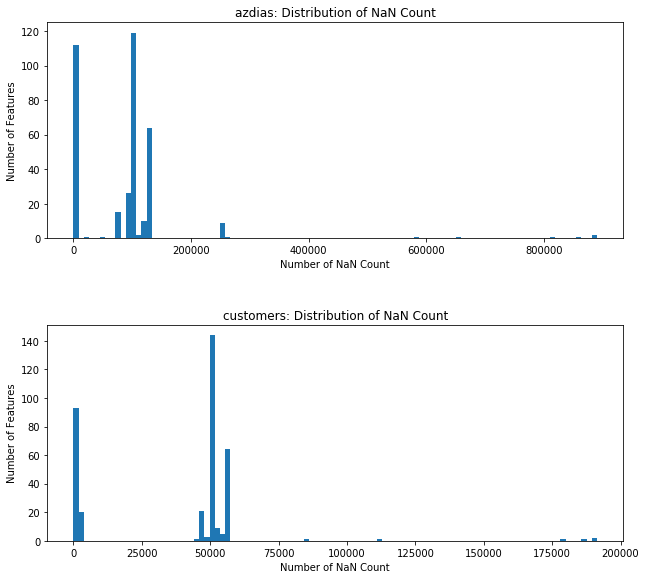

In [7]:
%%time
# Plot NaN count for each feature in azdias and customers dataset
nan_count_column_azdias = azdias.isnull().sum()
nan_count_column_customers = customers.isnull().sum()
bar_plt_nan(nan_count_column_azdias, nan_count_column_customers);

Wall time: 2.06 s


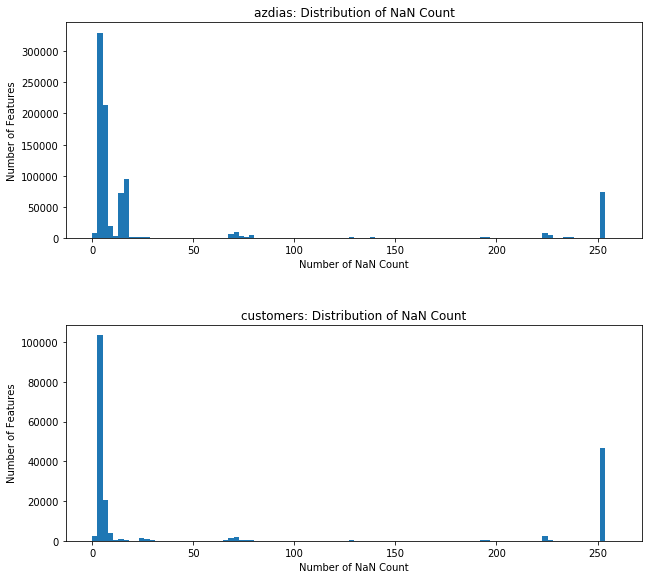

In [8]:
%%time
# Plot NaN count across each row in azdias and customers dataset
nan_count_row_azdias = azdias.isnull().sum(axis=1)
nan_count_row_customers = customers.isnull().sum(axis=1)
bar_plt_nan(nan_count_row_azdias, nan_count_row_customers);

**Observations:** The distribution of `NaN` count across both datasets are different. In `azdias` most of the columns have `NaN` count below 200,000; meaning 1 data in every 5 rows or 20% of the data are missing in each column. While in `customers` most of the columns have more than 50,000 data missing; in other words, 25% or 1 in every 4 rows data are missing.

For both `azdias` and `customers`, `NaN` count across rows are below 50. Therefore, in both dataset `NaN` count over 50 will be dropped.

### Check Features 
#### Create Features List from `attributes` and `attributes_desc`

In [9]:
# Features listed in "attributes" 
features_attributes = sorted(list(set(attributes.Attribute.tolist())))

# Features listed in attributes_desc 
features_attributes_desc = attributes_desc.Attribute.tolist()

# Multiple features in attributes_desc are grouped in a single string separated by whitespaces
# Split the multiple features into separate string
features_attributes_desc = sorted([feature for group_feature in features_attributes_desc for feature in group_feature.split()])

# Check if there is any unique features in attributes or in attributes_desc
unique_attributes_features = set(features_attributes) - set(features_attributes_desc)
unique_attributes_desc_features = set(features_attributes_desc) - set(features_attributes)
print("Unique attributes features: {}, Unique attributes_desc features: {}".format(len(unique_attributes_features),
                                                                                  len(unique_attributes_desc_features)))

# Combine all features and create the features list
features_list = sorted(list(set.union(set(features_attributes), set(features_attributes_desc))))
print("Total number of features: ", len(features_list))

Unique attributes features: 4, Unique attributes_desc features: 8
Total number of features:  322


#### Check Features of `azdias` and `customers`
Using `features_list` generated earlier, check how many features are present in `azdias` and `customers`

In [10]:
azdias_feat = azdias.columns.tolist()
customers_feat = customers.columns.tolist()

# First check if all the features from features_list are present in azdias and customers
common_azdias_feat = set(azdias_feat) & set(features_list)
common_customers_feat = set(customers_feat) & set(features_list)

print("Number of common features: azdias_feat: {}, customers_feat: {}".format(len(common_azdias_feat),
                                                                              len(common_customers_feat)))

Number of common features: azdias_feat: 276, customers_feat: 276


**Observations:** There are 8 features in `features_list` which are present in `attributes_desc`, but not in `attributes`. These features have descriptions but their encoded values cannot be found in `attributes`. Let's explore these features and their values in `azdias` before further analysis of all the datasets.

In [11]:
unique_attributes_desc_features = list(unique_attributes_desc_features)
azdias_subset = azdias.loc[:, unique_attributes_desc_features]
feat_info_azdias_subset = build_feat_info(azdias_subset)
feat_info_azdias_subset.sort_values(by=['percent_nans'], ascending=False)

C:\Users\Reza\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,value_count,value_distinct,num_nans,percent_nans
PLZ8,0,1,891221,1.000
PLZ,0,1,891221,1.000
GKZ,0,1,891221,1.000
EINWOHNER,0,1,891221,1.000
ARBEIT,794005,7,97216,0.109
D19_VERSI_ONLINE_DATUM,891221,10,0,0.000
D19_VERSI_OFFLINE_DATUM,891221,10,0,0.000
D19_VERSI_DATUM,891221,10,0,0.000


**Observations:** Features with 100% `NaN` counts will be dropped during the downstream data cleaning process. However, four features: i. `ARBEIT`, ii. `D19_VERSI_DATUM`, iii. `D19_VERSI_OFFLINE_DATUM` iv. `D19_VERSI_ONLINE_DATUM`, have relatively low `NaN` counts. These features should be preserved during data cleaning process. First, let's explore the distinct values for each columns since they are not described in `attributes`.

In [12]:
# Find distinct values for the 8 features
azdias_subset_distinct_val = pd.DataFrame({
                                "value_list" : [sorted(azdias_subset[x].unique()) for x in azdias_subset.columns]
                            }, index = azdias_subset.columns)
azdias_subset_distinct_val.sort_index()

,value_list
ARBEIT,"[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 9.0]"
D19_VERSI_DATUM,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
D19_VERSI_OFFLINE_DATUM,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
D19_VERSI_ONLINE_DATUM,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
EINWOHNER,[nan]
GKZ,[nan]
PLZ,[nan]
PLZ8,[nan]


**Assumption:** Referring to `DIAS Information Levels - Attributes 2017.xlsx`, `ARBEIT` belongs to community level features. Community level features also include `RELAT_AB` whose description is similar to `ARBEIT`. Therefore, value encoded for `RELAT_AB` will be used as reference for `ARBEIT`.

`D19_VERSI_DATUM`, `D19_VERSI_OFFLINE_DATUM`, and `D19_VERSI_ONLINE_DATUM` have no missing values and no encoding description is available for these features in `DIAS Attributes - Values 2017.xlsx`. Regardless, these features will remain in the datasets without any modifications.

### Data Cleaning
For some features listed in `DIAS Attributes - Values 2017.xlsx` **_unknown information_** are encoded to certain numbers. These values will be replaced with `NaN` in `azdias` and `customers` datasets.
1. Features whose information are available in `DIAS Information Levels - Attributes 2017.xlsx` or in `DIAS Attributes - Values 2017.xlsx`, will be selected for the analysis.  
2. The **_unknown information_** will be replaced with `NaN`.  
3. Both `azdias` and `customers` datasets will be compared and features with similar percentage of `NaN` count will be dropped.

#### Comparison of `NaN` count of Each Feature before Data Cleaning

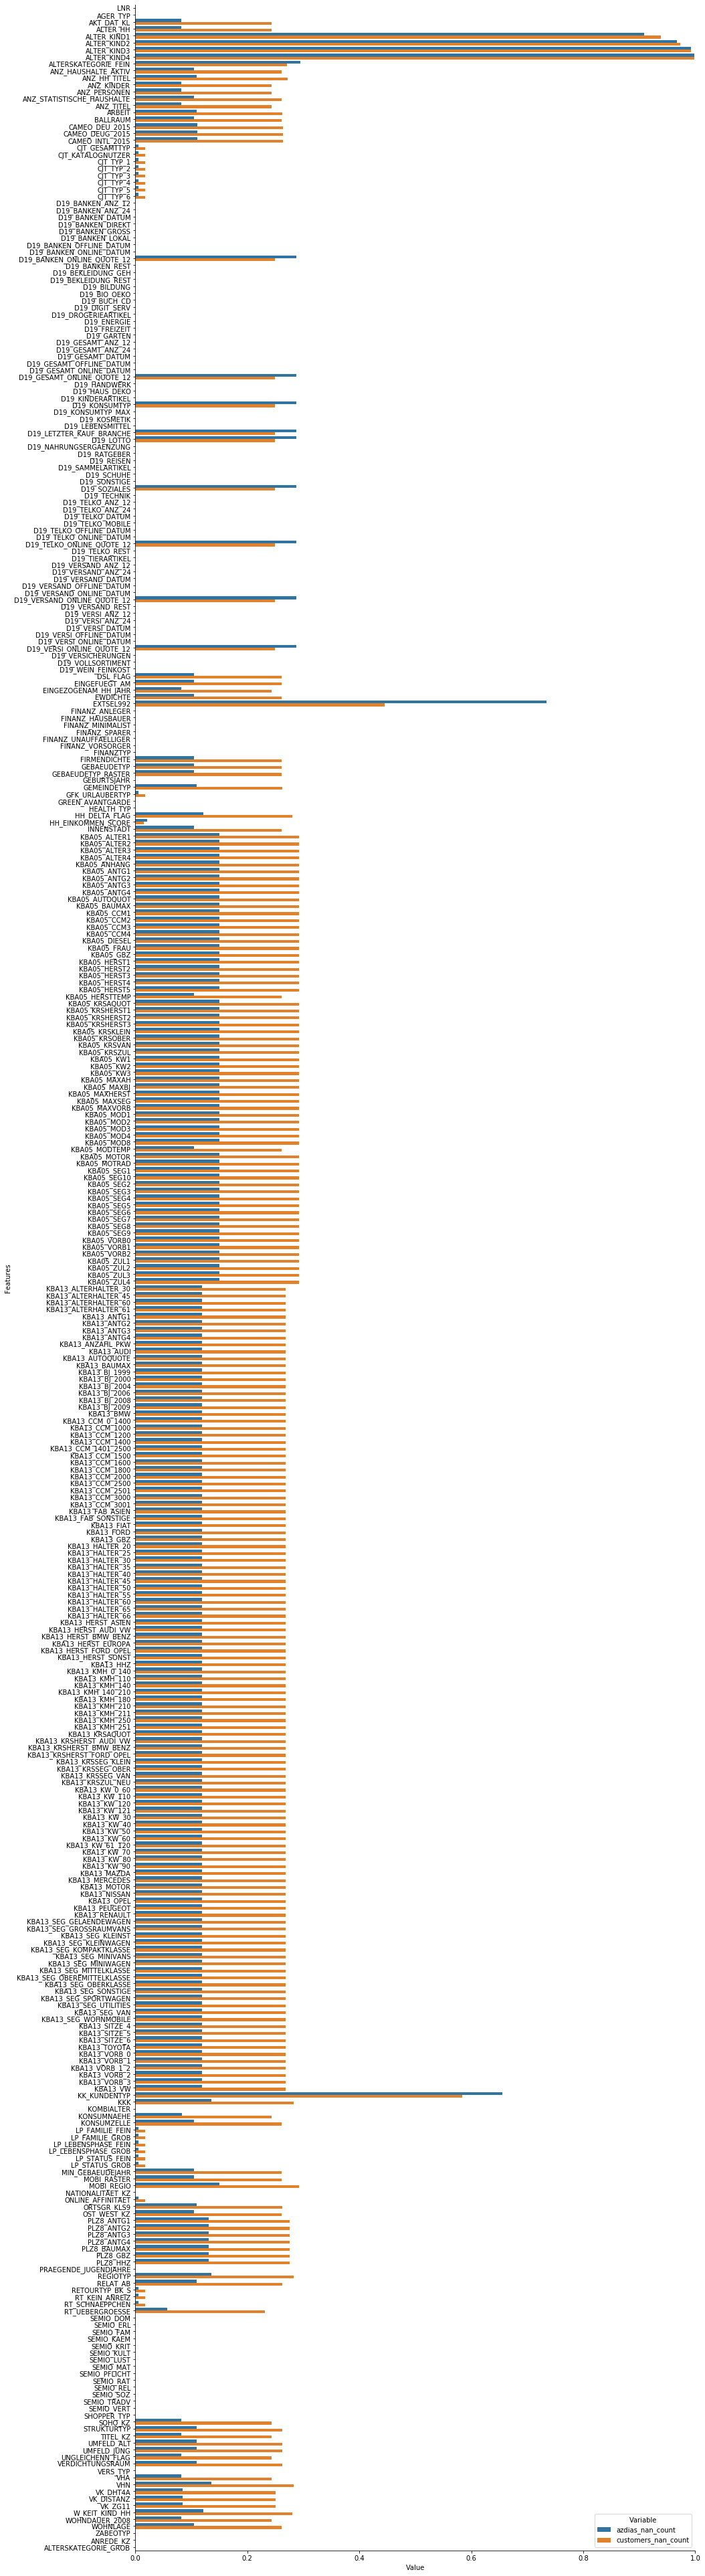

In [13]:
# Find NaN count for each features in azdias and customers dataset
columns_name = ["azdias_nan_count", "customers_nan_count"]
feature_nan_count = pd.concat([feat_info_azdias.loc[:, "percent_nans"], feat_info_customers.loc[:, "percent_nans"]], axis=1)
feature_nan_count.columns = columns_name
"""
feature_nan_count = pd.DataFrame({
                                "azdias_nan_count": [round(azdias[x].isnull().sum()/azdias[x].shape[0], 3) for x in azdias.columns],
                                "customers_nan_count": [round(customers[x].isnull().sum()/customers[x].shape[0], 3) for x in customers.columns]
                    }, index=azdias.columns)
"""
#feature_nan_count = feature_nan_count.loc[(feature_nan_count.azdias_nan_count <= 0.2) |
#                                                 (feature_nan_count.customers_nan_count <= 0.2)]
feature_nan_count = feature_nan_count.rename_axis("features").reset_index()

# Plot bar chart to see the distribution of NaN count of each feature in azdias and customers dataset
feature_nan_count_plot = feature_nan_count.melt(id_vars='features').rename(columns=str.title)
fig, ax1 = plt.subplots(figsize=(15, 70))
ax1.set(xlim=(0, 1))
sns.barplot(x="Value", y="Features", hue="Variable", data=feature_nan_count_plot, ax=ax1)
sns.despine(fig)
plt.savefig("feature_nan_count_pre_cleanup.png")

**Observations:** There are few features which have fine level information along with aggregated level information. These features are listed below:
1. `LP_FAMILIE_FEIN` & `LP_FAMILIE_GROB`  
2. `LP_LEBENSPHASE_FEIN` & `LP_LEBENSPHASE_GROB`  
3. `LP_STATUS_FEIN` &  `LP_STATUS_GROB`  
Depending on the number of encoded values & definitions, `LP_FAMILIE_GROB`, `LP_LEBENSPHASE_FEIN`, and `LP_STATUS_GROB` will be dropped. In addition, `CAMEO_DEU_2015` will be dropped as well since it contains fine level information as well.

In [14]:
drop_features = ["LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN", "LP_STATUS_GROB", "CAMEO_DEU_2015"]

In [15]:
%%time
azdias, customers = clean_data(azdias, customers, attributes, features_list, drop_features)

C:\Users\Reza\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Please wait: replacing unknown with NaN
Please wait: replacing unknown with NaN
Wall time: 3min 12s


```python
numerical_feat = ["ALTER_HH", "ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", "ANZ_TITEL", "GEBURTSJAHR",
                  "KBA13_ANZAHL_PKW", "MIN_GEBAEUDEJAHR"]
```

#### Code snippet
```python
azdias.to_csv("azdias_clean.csv", index=False)  
customers.to_csv("customers_clean.csv", index=False)
```

#### Comparison of `NaN` count of Each Feature after Data Cleaning

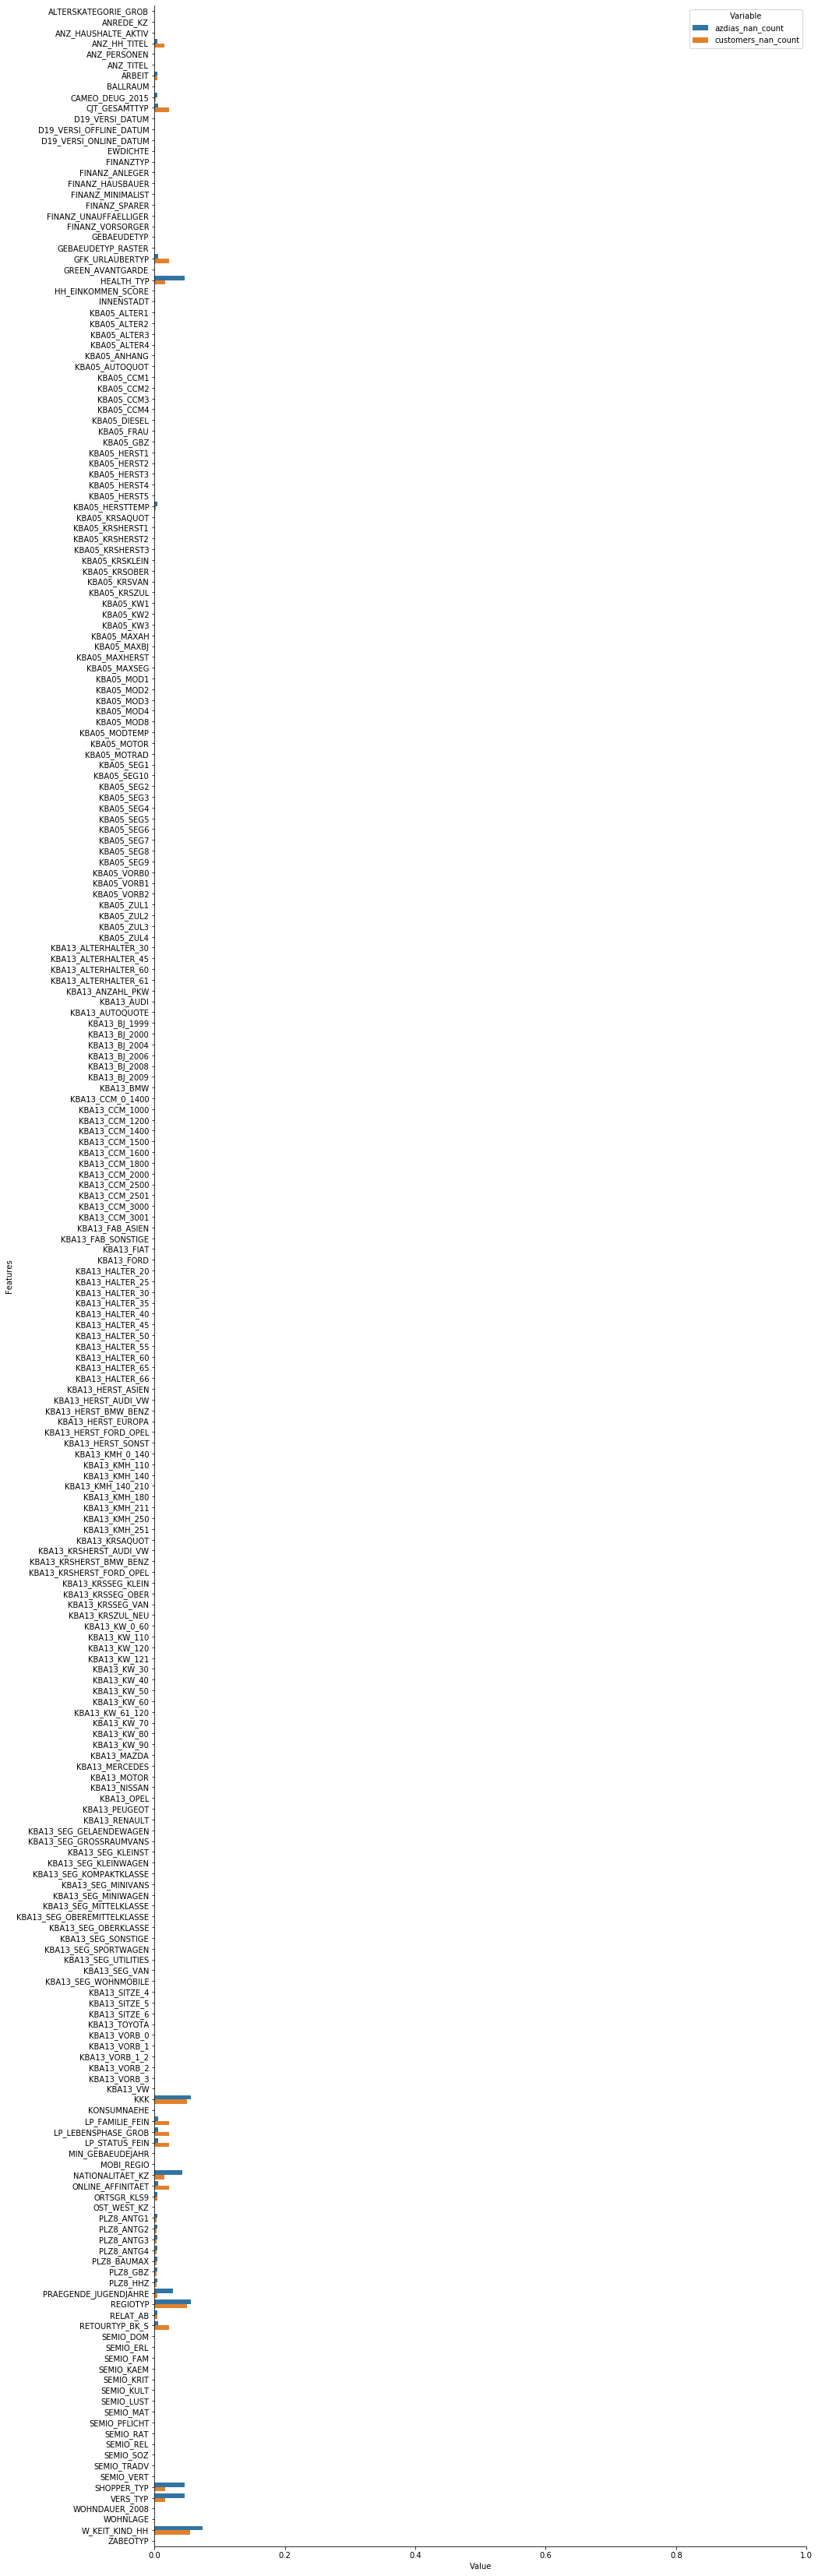

In [16]:
feature_nan_count = pd.DataFrame({
                                "azdias_nan_count": [round(azdias[x].isnull().sum()/azdias[x].shape[0], 3) for x in azdias.columns],
                                "customers_nan_count": [round(customers[x].isnull().sum()/customers[x].shape[0], 3) for x in customers.columns]
                    }, index=azdias.columns)
feature_nan_count = feature_nan_count.rename_axis("features").reset_index()
# Plot bar chart to see the distribution of each feature in azdias and customers dataset
feature_nan_count_plot = feature_nan_count.melt(id_vars='features').rename(columns=str.title)
fig, ax1 = plt.subplots(figsize=(15, 60))
ax1.set(xlim=(0, 1))
sns.barplot(x="Value", y="Features", hue="Variable", data=feature_nan_count_plot, ax=ax1)
sns.despine(fig)
plt.savefig("feature_nan_count_clean.png")

#### Comparison of values in features for the datasets
Plot and compare the value distribution for each features in `azdias` and `customers` dataset. To gauge if the data is balanced, five features will be chosen at random and the value distribution for each features will be plotted for `azdias` and `customers` datasets.

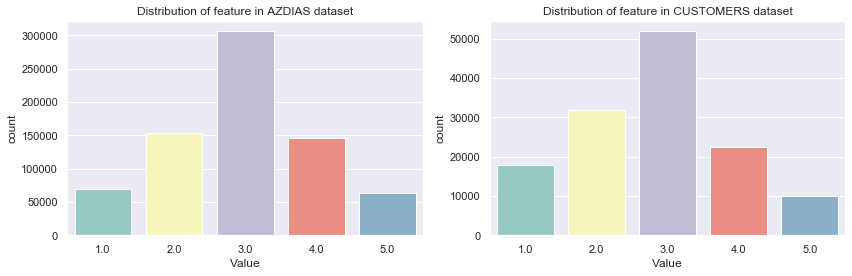

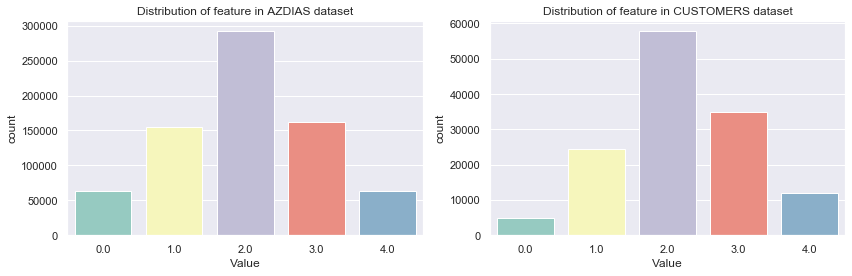

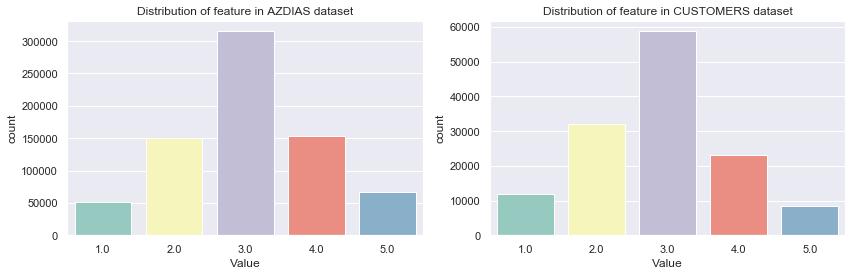

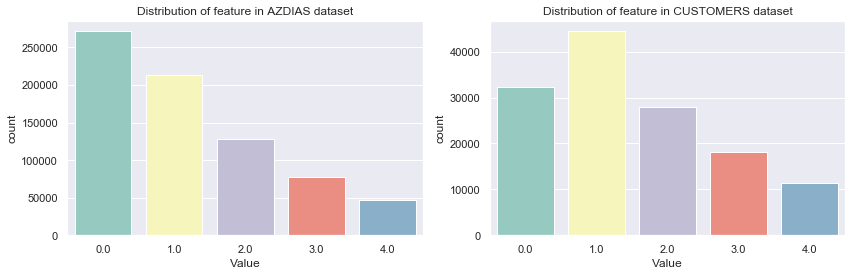

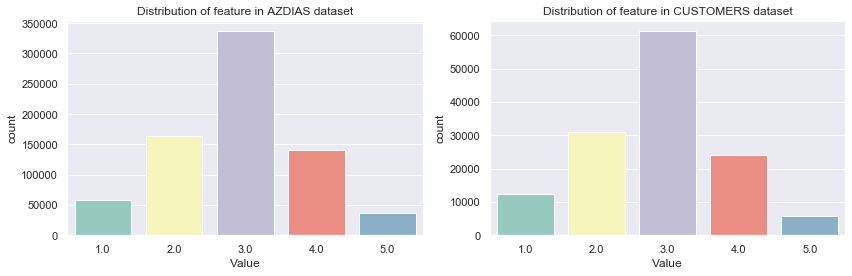

In [20]:
for i in range(5):
    plot_comparison(azdias.columns[random.randint(0, azdias.shape[1])], azdias, customers)

### Feature Encoding & Engineering
After cleaning the datasets, there are features which are numerical, categorical and ordinal in nature. In addition, data in `OST_WEST_KZ` are strings. Furthermore, even after cleaning the data, there are some `NaN` values which are needed to be imputed. Therefore, all the features are needed to be encoded and engineered properly.
1. Encoding `OST_WEST_KZ`: It is a binary categorical data where `W` will be mapped to 0 and `O` will be mapped to 1.  
2. Imputation Strategy:  
    * To impute numerical data, `median` will be used as strategy  
    * To impute categorical and nominal data `most_frequent` will be used as strategy
3. After encoding and imputation, the data will be standardized

In [ ]:
# OST_WEST_KZ needs to be encoded since the data are strings
azdias["OST_WEST_KZ"].replace(["W", "O"], [0, 1], inplace=True)
customers["OST_WEST_KZ"].replace(["W", "O"], [0, 1], inplace=True)

In [ ]:
# Impute numeric columns
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='median')
azdias = pd.DataFrame(imputer_numeric.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer_numeric.fit_transform(customers), columns = customers.columns)